# Stage 2: Bacterial vs. Viral - NO MASK (CV)

Grayscale - 1 Channel CXR

In [1]:
import pandas as pd
import math
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization, AveragePooling2D, Conv2D, MaxPool2D, Activation, GlobalAveragePooling2D, Lambda
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [2]:
# Config
IMG_SIZE = 256
BATCH_SIZE=32
CHANNELS=1
USE_MASKS=False
MODELSAVE = "models/cnn_gray_stage2_130120"

if(USE_MASKS):
    MODELSAVE += "_w_masks.h5"
else:
    MODELSAVE += "_wo_masks.h5"


# train_path = '/home/daniel/.kaggle/mooney/chest_xray/train/'
# test_path = '/home/8cb7/.kaggle/mooney/chest_xray/test/'
# val_path = '/home/8cb7/.kaggle/mooney/chest_xray/val/'

train_path = '/home/daniel/dev/python/chest_x_ray/data/mooney/train/'
test_path = '/home/daniel/dev/python/chest_x_ray/data/mooney/test/'
val_path = '/home/daniel/dev/python/chest_x_ray/data/mooney/val/'

train_mask_path = '/home/daniel/dev/python/chest_x_ray/data/mooney/masks/train/'
val_mask_path = '/home/daniel/dev/python/chest_x_ray/data/mooney/masks/test/'
test_mask_path = '/home/daniel/dev/python/chest_x_ray/data/mooney/masks/val/'

# train_mask_path = '/home/8cb7/.kaggle/mooney/chest_xray/masks/train/'
# val_mask_path = '/home/8cb7/.kaggle/mooney/chest_xray/masks/val/'
# test_mask_path = '/home/8cb7/.kaggle/mooney/chest_xray/masks/test/'

# covid19
covid_path = '/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output'
covid_mask_path = '/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41//masks/'

In [3]:
USE_MASKS

False

In [4]:
# np.random.seed(200)
# tf.random.set_seed(200)

## 1 Data preparation

In [5]:
def load_images_from_folder(img_folder, masks_folder):
    tmp_df = pd.DataFrame(columns = ['img', 'label', 'mask']) 
    # IMGs
    for label_folder in os.listdir(img_folder):
        for filename in os.listdir(img_folder + '/' + label_folder):
            img_path = str(img_folder)+str(label_folder)+'/'+str(filename)
            # normal file ending is jpEg...
            filename_wo_ending = filename.split('.jpeg')[0]

            mask_path = None
            if masks_folder is not None:
                mask_path = str(masks_folder)+str(label_folder)+'/'+str(filename_wo_ending) + '_predmask.jpg'

            label2 = '-'
            if img_path is not None:
                if label_folder != 'NORMAL':
                    label2 = filename_wo_ending.split("_")[1].split("_")[0]

                tmp_df = tmp_df.append({'img': img_path, 'mask': mask_path, 'label': label_folder, 'label2': label2, 'label3': '-'}, ignore_index=True)

    return tmp_df

In [6]:
def load_covid_images_from_folder(img_folder, masks_folder):
    tmp_df = pd.DataFrame(columns = ['img', 'label', 'mask']) 
    for filename in os.listdir(img_folder):
        img_path = str(img_folder)+'/'+str(filename)
        label = 'PNEUMONIA' # virus => covid19
        # normal file ending is jpEg...
        filename_wo_ending = filename.rsplit('.')[0]
        mask_path = str(masks_folder)+'/'+str(filename_wo_ending) + '_predmask.jpg'
        if img_path is not None:
            tmp_df = tmp_df.append({'img': img_path,  'mask': mask_path, 'label': label, 'label2': 'virus', 'label3': 'covid19'}, ignore_index=True)

    return tmp_df

In [7]:
df_train = load_images_from_folder(train_path, None)
df_val = load_images_from_folder(val_path, None)
df_test = load_images_from_folder(test_path, None)
df_covid = load_covid_images_from_folder(covid_path, None)

In [8]:
df_train.shape

(5216, 5)

In [9]:
df_train = df_train.append(df_val, ignore_index=True) # append val to train since we are using k-fold cv

In [10]:
df_train

,img,label,mask,label2,label3
0,/home/daniel/dev/python/chest_x_ray/data/moone...,PNEUMONIA,None,bacteria,-
1,/home/daniel/dev/python/chest_x_ray/data/moone...,PNEUMONIA,None,virus,-
2,/home/daniel/dev/python/chest_x_ray/data/moone...,PNEUMONIA,None,virus,-
3,/home/daniel/dev/python/chest_x_ray/data/moone...,PNEUMONIA,None,bacteria,-
4,/home/daniel/dev/python/chest_x_ray/data/moone...,PNEUMONIA,None,bacteria,-
...,...,...,...,...,...
5227,/home/daniel/dev/python/chest_x_ray/data/moone...,NORMAL,None,-,-
5228,/home/daniel/dev/python/chest_x_ray/data/moone...,NORMAL,None,-,-
5229,/home/daniel/dev/python/chest_x_ray/data/moone...,NORMAL,None,-,-
5230,/home/daniel/dev/python/chest_x_ray/data/moone...,NORMAL,None,-,-


In [11]:
df_train.shape

(5232, 5)

In [12]:
df_covid.head()

,img,label,mask,label2,label3
0,/home/daniel/dev/python/chest_x_ray/data/covid...,PNEUMONIA,None/a2eba651_predmask.jpg,virus,covid19
1,/home/daniel/dev/python/chest_x_ray/data/covid...,PNEUMONIA,None/nejmoa2001191_f1-PA_predmask.jpg,virus,covid19
2,/home/daniel/dev/python/chest_x_ray/data/covid...,PNEUMONIA,None/7-fatal-covid19_predmask.jpg,virus,covid19
3,/home/daniel/dev/python/chest_x_ray/data/covid...,PNEUMONIA,None/ciaa199_predmask.jpg,virus,covid19
4,/home/daniel/dev/python/chest_x_ray/data/covid...,PNEUMONIA,None/7AF6C1AF-D249-4BD2-8C26-449304105D03_pred...,virus,covid19


In [13]:
# Split covid19 data
from sklearn.model_selection import train_test_split
df_train_covid, df_test_covid = train_test_split(df_covid, test_size=0.2, random_state=200)

In [14]:
print('=== Covid Data: ===')
print('Train:', len(df_train_covid))
print('Test:', len(df_test_covid))

=== Covid Data: ===
Train: 156
Test: 40


In [15]:
# remove normal images
df_train = df_train[df_train.label != 'NORMAL']
df_test = df_test[df_test.label != 'NORMAL']

In [16]:
pd.set_option('display.max_colwidth', -1)
df_train_covid

,img,label,mask,label2,label3
166,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/3b46de94.jpg,PNEUMONIA,None/3b46de94_predmask.jpg,virus,covid19
80,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/1-s2.0-S0140673620303706-fx1_lrg.jpg,PNEUMONIA,None/1-s2_predmask.jpg,virus,covid19
174,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/48c4542c.jpg,PNEUMONIA,None/48c4542c_predmask.jpg,virus,covid19
180,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/2C26F453-AF3B-4517-BB9E-802CF2179543.jpeg,PNEUMONIA,None/2C26F453-AF3B-4517-BB9E-802CF2179543_predmask.jpg,virus,covid19
163,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/23E99E2E-447C-46E5-8EB2-D35D12473C39.png,PNEUMONIA,None/23E99E2E-447C-46E5-8EB2-D35D12473C39_predmask.jpg,virus,covid19
...,...,...,...,...,...
42,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/covid-19-pneumonia-rapidly-progressive-3-days.jpg,PNEUMONIA,None/covid-19-pneumonia-rapidly-progressive-3-days_predmask.jpg,virus,covid19
68,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-002-fig3a.png,PNEUMONIA,None/1_predmask.jpg,virus,covid19
16,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/ryct.2020200034.fig5-day0.jpeg,PNEUMONIA,None/ryct_predmask.jpg,virus,covid19
105,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/covid-19-pneumonia-rapidly-progressive-12-hours.jpg,PNEUMONIA,None/covid-19-pneumonia-rapidly-progressive-12-hours_predmask.jpg,virus,covid19


In [17]:
# Append Covid19 data to rest
df_train = df_train.append(df_train_covid, ignore_index=True)
df_test = df_test.append(df_test_covid, ignore_index=True)

In [18]:
print('=== Train Data: ===')
print('Normal:', len(df_train[df_train['label'] == 'NORMAL']))
print('Pneumonia:', len(df_train[df_train['label'] == 'PNEUMONIA']))
print('|---> Bacterial:', len(df_train[df_train['label2'] == 'bacteria']))
print('|---> Viral:', len(df_train[df_train['label2'] == 'virus']))
print('    |---> Covid:', len(df_train[df_train['label3'] == 'covid19']))

=== Train Data: ===
Normal: 0
Pneumonia: 4039
|---> Bacterial: 2538
|---> Viral: 1501
    |---> Covid: 156


In [19]:
print('=== Test Data: ===')
print('Normal:', len(df_test[df_test['label'] == 'NORMAL']))
print('Pneumonia:', len(df_test[df_test['label'] == 'PNEUMONIA']))
print('|---> Bacterial:', len(df_test[df_test['label2'] == 'bacteria']))
print('|---> Viral:', len(df_test[df_test['label2'] == 'virus']))
print('    |---> Covid:', len(df_test[df_test['label3'] == 'covid19']))

=== Test Data: ===
Normal: 0
Pneumonia: 430
|---> Bacterial: 242
|---> Viral: 188
    |---> Covid: 40


In [20]:
# Shuffle
df_train = df_train.sample(frac=1, random_state=200).reset_index(drop=True)
df_test = df_test.sample(frac=1, random_state=200).reset_index(drop=True)

In [21]:
def replace_by_binary_class(df, to_replace, value):
    return df.replace(to_replace=to_replace, value=value)

In [22]:
df_train = replace_by_binary_class(df_train, 'bacteria', 0)
df_train = replace_by_binary_class(df_train, 'virus', 1)

df_test = replace_by_binary_class(df_test, 'bacteria', 0)
df_test = replace_by_binary_class(df_test, 'virus', 1)

In [23]:
df_train.head()

,img,label,mask,label2,label3
0,/home/daniel/dev/python/chest_x_ray/data/mooney/train/PNEUMONIA/person465_virus_957.jpeg,PNEUMONIA,None,1,-
1,/home/daniel/dev/python/chest_x_ray/data/mooney/train/PNEUMONIA/person1729_bacteria_4557.jpeg,PNEUMONIA,None,0,-
2,/home/daniel/dev/python/chest_x_ray/data/mooney/train/PNEUMONIA/person1180_virus_2009.jpeg,PNEUMONIA,None,1,-
3,/home/daniel/dev/python/chest_x_ray/data/mooney/train/PNEUMONIA/person1206_virus_2051.jpeg,PNEUMONIA,None,1,-
4,/home/daniel/dev/python/chest_x_ray/data/mooney/train/PNEUMONIA/person1176_virus_1998.jpeg,PNEUMONIA,None,1,-



## 2 Data generator

In [24]:
import imgaug.augmenters as iaa
aug = iaa.AllChannelsCLAHE(clip_limit=(0.05))

In [25]:
def applySigmoidContrast(img):
    img = aug.augment_image(img)
    return img

In [26]:
import imgaug as ia
import imgaug.augmenters as iaa

sometimes = lambda aug: iaa.Sometimes(0.5, aug)
sometimes25 = lambda aug: iaa.Sometimes(0.25, aug)

seq_img = iaa.Sequential([
    # sometimes(iaa.SigmoidContrast(gain=(3, 10), cutoff=(0.4, 0.6))),
    sometimes(iaa.Affine(
            rotate=(-10, 10),
            shear=(-10,10),
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
            translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}
    )),
    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.15))),
], random_order=True)

class DataGenerator(tf.keras.utils.Sequence):

    def __init__(self, df, augment, img_size, batch_size=8, shuffle=True, useMasks=True):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.augment = augment
        self.img_size = img_size
        self.useMasks = useMasks

    def __len__(self):
        return math.ceil(len(self.indices)/ self.batch_size)

    def __getitem__(self, index):
        indexes = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch = [self.indices[k] for k in indexes]
        X, y = self.__get_data(batch)
        return np.array(X), np.array(y)

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __get_data(self, batch):
        X_img_paths = self.df['img']
        X_mask_paths = self.df['mask']
        X_imgs = []
        X_masks = []
        Y = self.df['label2'].iloc[batch].to_numpy()

        for i in range(0, len(batch)):
            img = cv2.resize(cv2.imread(str(X_img_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE), (self.img_size, self.img_size))
            img = img.reshape(img.shape[0], img.shape[1],1)

            if not self.useMasks:
                if(self.augment is True):
                    seq_img_i = seq_img.to_deterministic()   
                    img = seq_img_i.augment_image(img)
                # else img remains untouched
            else: 
                mask = cv2.imread(str(X_mask_paths.iloc[batch[i]]), cv2.IMREAD_GRAYSCALE)
                #mask = cv2.resize(mask, (self.img_size, self.img_size))
                mask = cv2.threshold(mask,0,1,cv2.THRESH_BINARY)[1]
                # Multiply binarized mask on grayscaled version of the x-ray. 
                # So only the lung will remain, everything else will be set to 0
                try:
                    mask = mask.reshape(IMG_SIZE,IMG_SIZE,1)
                except:
                    print("i", i)
                    print(str(X_mask_paths.iloc[batch[i]]))
                cutout_img = img * mask
                cutout_img = cutout_img.reshape(IMG_SIZE,IMG_SIZE,1)

                if(self.augment is True):
                    seq_img_i = seq_img.to_deterministic()   
                    img = seq_img_i.augment_image(img) #### img
                    cutout_img = seq_img_i.augment_image(cutout_img) #### cutout

                img = np.dstack([img, cutout_img])
                mask = mask / 255.0

            # normalize
            img = img / 255.0

            X_imgs.append(img)

        return X_imgs, Y

## 3 Model training

In [27]:
def getModel():
    model = Sequential()
    # Conv block1 = cb0
    model.add(Conv2D(32, (3,3), padding = "same", activation='relu', input_shape=(IMG_SIZE,IMG_SIZE,CHANNELS), name="cb0_conv0"))
    model.add(Conv2D(32, (3,3), padding = "same", activation='relu', name="cb0_conv1"))
    model.add(MaxPool2D(pool_size = (3, 3), name="cb0_maxpool"))
    model.add(Dropout(0.2, name="cb0_dropout"))

    # Conv block2 = cb1
    model.add(Conv2D(64, (3,3), padding = "same", activation='relu', name="cb1_conv0"))
    model.add(Conv2D(64, (5,5), strides=(2,2), padding = "same", activation='relu', name="cb1_conv1"))
    model.add(Conv2D(64, (3,3), padding = "same", activation='relu', name="cb1_conv2"))
    model.add(MaxPool2D(pool_size = (2, 2), name="cb1_maxpool"))
    model.add(Dropout(0.2, name="cb1_dropout"))

    # Dense block = db
    model.add(Flatten())
    model.add(Dense(1024, activation='relu', name="db_dense1024"))
    model.add(Dense(512, activation='relu', name="db_dense512"))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu', name="db_dense256"))
    model.add(Dropout(0.2))

    model.add(Dense(1, activation='sigmoid', name="db_dense1"))

    model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    return model

In [28]:
# K-Fold
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, accuracy_score

In [29]:
kf5 = StratifiedKFold(n_splits=5, random_state=200)

In [30]:
run = 1
val_scores = []
f1_scores = []
histories = []
best_f1_model = None
highestF1 = 0
EPOCHS = 12

for train_index, val_index in kf5.split(df_train, df_train.label2):
    print("Fold Nr.: ", run)
    df_fold_train = df_train.iloc[train_index]
    df_fold_val = df_train.iloc[val_index]

    df_fold_train.reset_index(drop=True, inplace=True)
    df_fold_val.reset_index(drop=True, inplace=True)
    
    
    # print('=== Train Data: ===')
    # print('Normal:', len(df_fold_train[df_fold_train['label'] == 0]))
    # print('Pneumonia:', len(df_fold_train[df_fold_train['label'] == 1]))
    # print('|---> Bacterial:', len(df_fold_train[df_fold_train['label2'] == 'bacteria']))
    # print('|---> Viral:', len(df_fold_train[df_fold_train['label2'] == 'virus']))
    # print('    |---> Covid:', len(df_fold_train[df_fold_train['label3'] == 'covid19']))
    
    # print('=== Val Data: ===')
    # print('Normal:', len(df_fold_val[df_fold_val['label'] == 0]))
    # print('Pneumonia:', len(df_fold_val[df_fold_val['label'] == 1]))
    # print('|---> Bacterial:', len(df_fold_val[df_fold_val['label2'] == 'bacteria']))
    # print('|---> Viral:', len(df_fold_val[df_fold_val['label2'] == 'virus']))
    # print('    |---> Covid:', len(df_fold_val[df_fold_val['label3'] == 'covid19']))
    
    train_generator = DataGenerator(df_fold_train, True, IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False, useMasks=USE_MASKS)
    val_generator = DataGenerator(df_fold_val, False, IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False, useMasks=USE_MASKS)
    
    # Adjust class_weights since we're dealing with imbalanced data here
    class_weights = class_weight.compute_class_weight('balanced', np.unique(df_fold_train['label2']), df_fold_train['label2'])
    class_weights = {0: class_weights[0], 1: class_weights[1]}
    print("Class weights: ", class_weights)

    model = getModel()
    history = model.fit(train_generator,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    steps_per_epoch=len(train_generator),
                    epochs=EPOCHS,
                    class_weight=class_weights,
                    #callbacks=[mcp_save, learning_rate_reduction], # learning_rate_reduction]],
                    verbose = True)

    predictions = model.predict(val_generator)
    y_pred = (predictions > 0.5).astype('uint8')

    histories.append(history)

    f1 = f1_score(y_pred, df_fold_val.label2)

    if(highestF1 is 0):
        highestF1 = f1
        best_f1_model = model
    else:
        if(f1 > highestF1):
            highestF1 = f1
            best_f1_model = model

    val_acc = accuracy_score(y_pred , df_fold_val.label2)

    f1_scores.append(f1)
    val_scores.append(val_acc)
    
    run += 1

Fold Nr.:  1
Class weights:  {0: 0.7954209748892171, 1: 1.34625}
Epoch 1/12
101/101 [==============================] - 28s 276ms/step - loss: 0.6941 - accuracy: 0.4704 - val_loss: 0.6907 - val_accuracy: 0.6918
Epoch 2/12
101/101 [==============================] - 21s 206ms/step - loss: 0.6901 - accuracy: 0.4924 - val_loss: 0.6688 - val_accuracy: 0.6795
Epoch 3/12
101/101 [==============================] - 20s 199ms/step - loss: 0.6704 - accuracy: 0.5843 - val_loss: 0.6235 - val_accuracy: 0.6745
Epoch 4/12
101/101 [==============================] - 21s 203ms/step - loss: 0.6541 - accuracy: 0.6076 - val_loss: 0.5811 - val_accuracy: 0.7042
Epoch 5/12
101/101 [==============================] - 20s 202ms/step - loss: 0.6217 - accuracy: 0.6583 - val_loss: 0.5304 - val_accuracy: 0.7463
Epoch 6/12
101/101 [==============================] - 21s 205ms/step - loss: 0.6254 - accuracy: 0.6407 - val_loss: 0.5266 - val_accuracy: 0.7512
Epoch 7/12
101/101 [==============================] - 21s 210ms/s

In [53]:
np.array(f1_scores).mean()

0.67976440091392

In [54]:
np.array(val_scores).mean()

0.7469634509919394

In [55]:
# set model to the best f1 model
model = best_f1_model

## 4 Model evaluation

In [40]:
# model = tf.keras.models.load_model("models/custom_0709_womasks.h5", compile=True)

In [56]:
df_test.head()

,img,label,mask,label2,label3
0,/home/daniel/dev/python/chest_x_ray/data/mooney/test/PNEUMONIA/person35_virus_80.jpeg,PNEUMONIA,None,1,-
1,/home/daniel/dev/python/chest_x_ray/data/mooney/test/PNEUMONIA/person1608_virus_2786.jpeg,PNEUMONIA,None,1,-
2,/home/daniel/dev/python/chest_x_ray/data/mooney/test/PNEUMONIA/person76_virus_138.jpeg,PNEUMONIA,None,1,-
3,/home/daniel/dev/python/chest_x_ray/data/covid-chestxray-dataset-0.41/output/radiol.2020200274.fig3d.png,PNEUMONIA,None/radiol_predmask.jpg,1,covid19
4,/home/daniel/dev/python/chest_x_ray/data/mooney/test/PNEUMONIA/person78_virus_140.jpeg,PNEUMONIA,None,1,-


In [57]:
test_generator = DataGenerator(df_test, False, IMG_SIZE, batch_size=32, shuffle=False, useMasks=USE_MASKS)

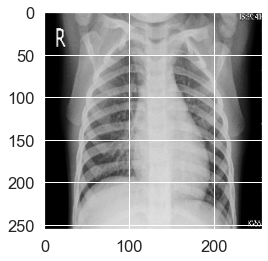

In [58]:
plt.imshow(test_generator.__getitem__(0)[0][0][:,:,0], cmap="gray")

In [59]:
model.evaluate(test_generator)

14/14 [==============================] - 2s 108ms/step - loss: 0.3020 - accuracy: 0.8977


[0.3020165264606476, 0.8976744413375854]

In [60]:
print("Test viral cases: ", len(df_test[df_test['label2'] == 0]))
print("Test bacteria cases: ", len(df_test[df_test['label2'] == 1]))

Test viral cases:  242
Test bacteria cases:  188


## Detail eval

In [61]:
predictions = model.predict(test_generator)

In [62]:
y_true = test_generator.df.label2 # we can do this since we do not shuffle in test_generator ;)
y_pred = predictions > 0.5

In [63]:
y_pred_classes = []

for x in y_pred:
    if x == 0:
        y_pred_classes.append("bacterial")
    else:
        y_pred_classes.append("viral")

In [64]:
y_true_classes = []

for x in y_true:
    if x == 0:
        y_true_classes.append("bacterial")
    else:
        y_true_classes.append("viral")

In [65]:
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[223  19]
 [ 25 163]]


In [66]:
report = classification_report(y_true_classes, y_pred_classes) #, target_names=["NORMAL", "PNEUMONIA"])
print(report)

              precision    recall  f1-score   support

   bacterial       0.90      0.92      0.91       242
       viral       0.90      0.87      0.88       188

    accuracy                           0.90       430
   macro avg       0.90      0.89      0.90       430
weighted avg       0.90      0.90      0.90       430



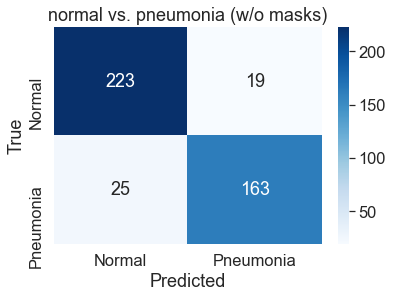

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Blues'); #annot=True to annotate cells
sns.set(font_scale=1.5)

# labels, title and ticks
ax.set_xlabel('Predicted');
ax.set_ylabel('True'); 
ax.set_title('normal vs. pneumonia (w/o masks)'); 
ax.xaxis.set_ticklabels(['Normal', 'Pneumonia']); ax.yaxis.set_ticklabels(['Normal', 'Pneumonia']);